In [5]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# **Data Preprocessing**

### **Read data and store it in dataframe**

In [2]:
# Generate data paths with labels
data_directory = 'Data/data_yawning/train'
file_paths = []
labels_list = []

folders_list = os.listdir(data_directory)
for folder_name in folders_list:
    folder_path = os.path.join(data_directory, folder_name)
    file_list = os.listdir(folder_path)
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        file_paths.append(file_path)
        labels_list.append(folder_name)

# Concatenate data paths with labels into one dataframe
file_series = pd.Series(file_paths, name='filepaths')
label_series = pd.Series(labels_list, name='labels')
data_df = pd.concat([file_series, label_series], axis=1)

In [3]:
data_df

,filepaths,labels
0,Data/data_yawning/train\no_yawn\1697289520325.jpg,no_yawn
1,Data/data_yawning/train\no_yawn\1697289532436.jpg,no_yawn
2,Data/data_yawning/train\no_yawn\1697289538220.jpg,no_yawn
3,Data/data_yawning/train\no_yawn\1697289543020.jpg,no_yawn
4,Data/data_yawning/train\no_yawn\1697289546700.jpg,no_yawn
...,...,...
53014,Data/data_yawning/train\yawn\augmented_1697321...,yawn
53015,Data/data_yawning/train\yawn\augmented_1697321...,yawn
53016,Data/data_yawning/train\yawn\augmented_1697321...,yawn
53017,Data/data_yawning/train\yawn\augmented_1697321...,yawn


### **Split dataframe into train, valid, and test**

In [4]:
# Train dataframe
train_df, valid_df = train_test_split(data_df, train_size=0.8, shuffle=True, random_state=123)

### Read test data and store it in dataframe

In [5]:
# Generate data paths with labels
test_directory = 'Data/data_yawning/test'
test_file_paths = []
test_labels = []

test_folders = os.listdir(test_directory)
for folder in test_folders:
    folder_path = os.path.join(test_directory, folder)
    file_list = os.listdir(folder_path)
    for file in file_list:
        file_path = os.path.join(folder_path, file)
        test_file_paths.append(file_path)
        test_labels.append(folder)

# Concatenate data paths with labels into one dataframe
test_file_series = pd.Series(test_file_paths, name='filepaths')
test_label_series = pd.Series(test_labels, name='labels')
test_df = pd.concat([test_file_series, test_label_series], axis=1)


### **Create image data generator**

In [6]:
# Cropped image size
batch_size = 16
image_size = (224, 224)
channels = 3
image_shape = (image_size[0], image_size[1], channels)

# Recommended: use a custom function for test data batch size, else we can use the normal batch size.
test_length = len(test_df)
test_batch_size = max(sorted([test_length // n for n in range(1, test_length + 1) if test_length % n == 0 and test_length / n <= 80]))
test_steps = test_length // test_batch_size

# This function will be used in the image data generator for data augmentation, it just takes the image and returns it again.
def scalar(img):
    return img

train_gen = ImageDataGenerator(preprocessing_function=scalar)
valid_gen = ImageDataGenerator(preprocessing_function=scalar)
test_gen = ImageDataGenerator(preprocessing_function=scalar)

train_generator = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=image_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_generator = valid_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=image_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# Note: we will use custom test_batch_size, and make shuffle=False
test_generator = test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=image_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 42415 validated image filenames belonging to 2 classes.
Found 10604 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


### **Show sample from train data**

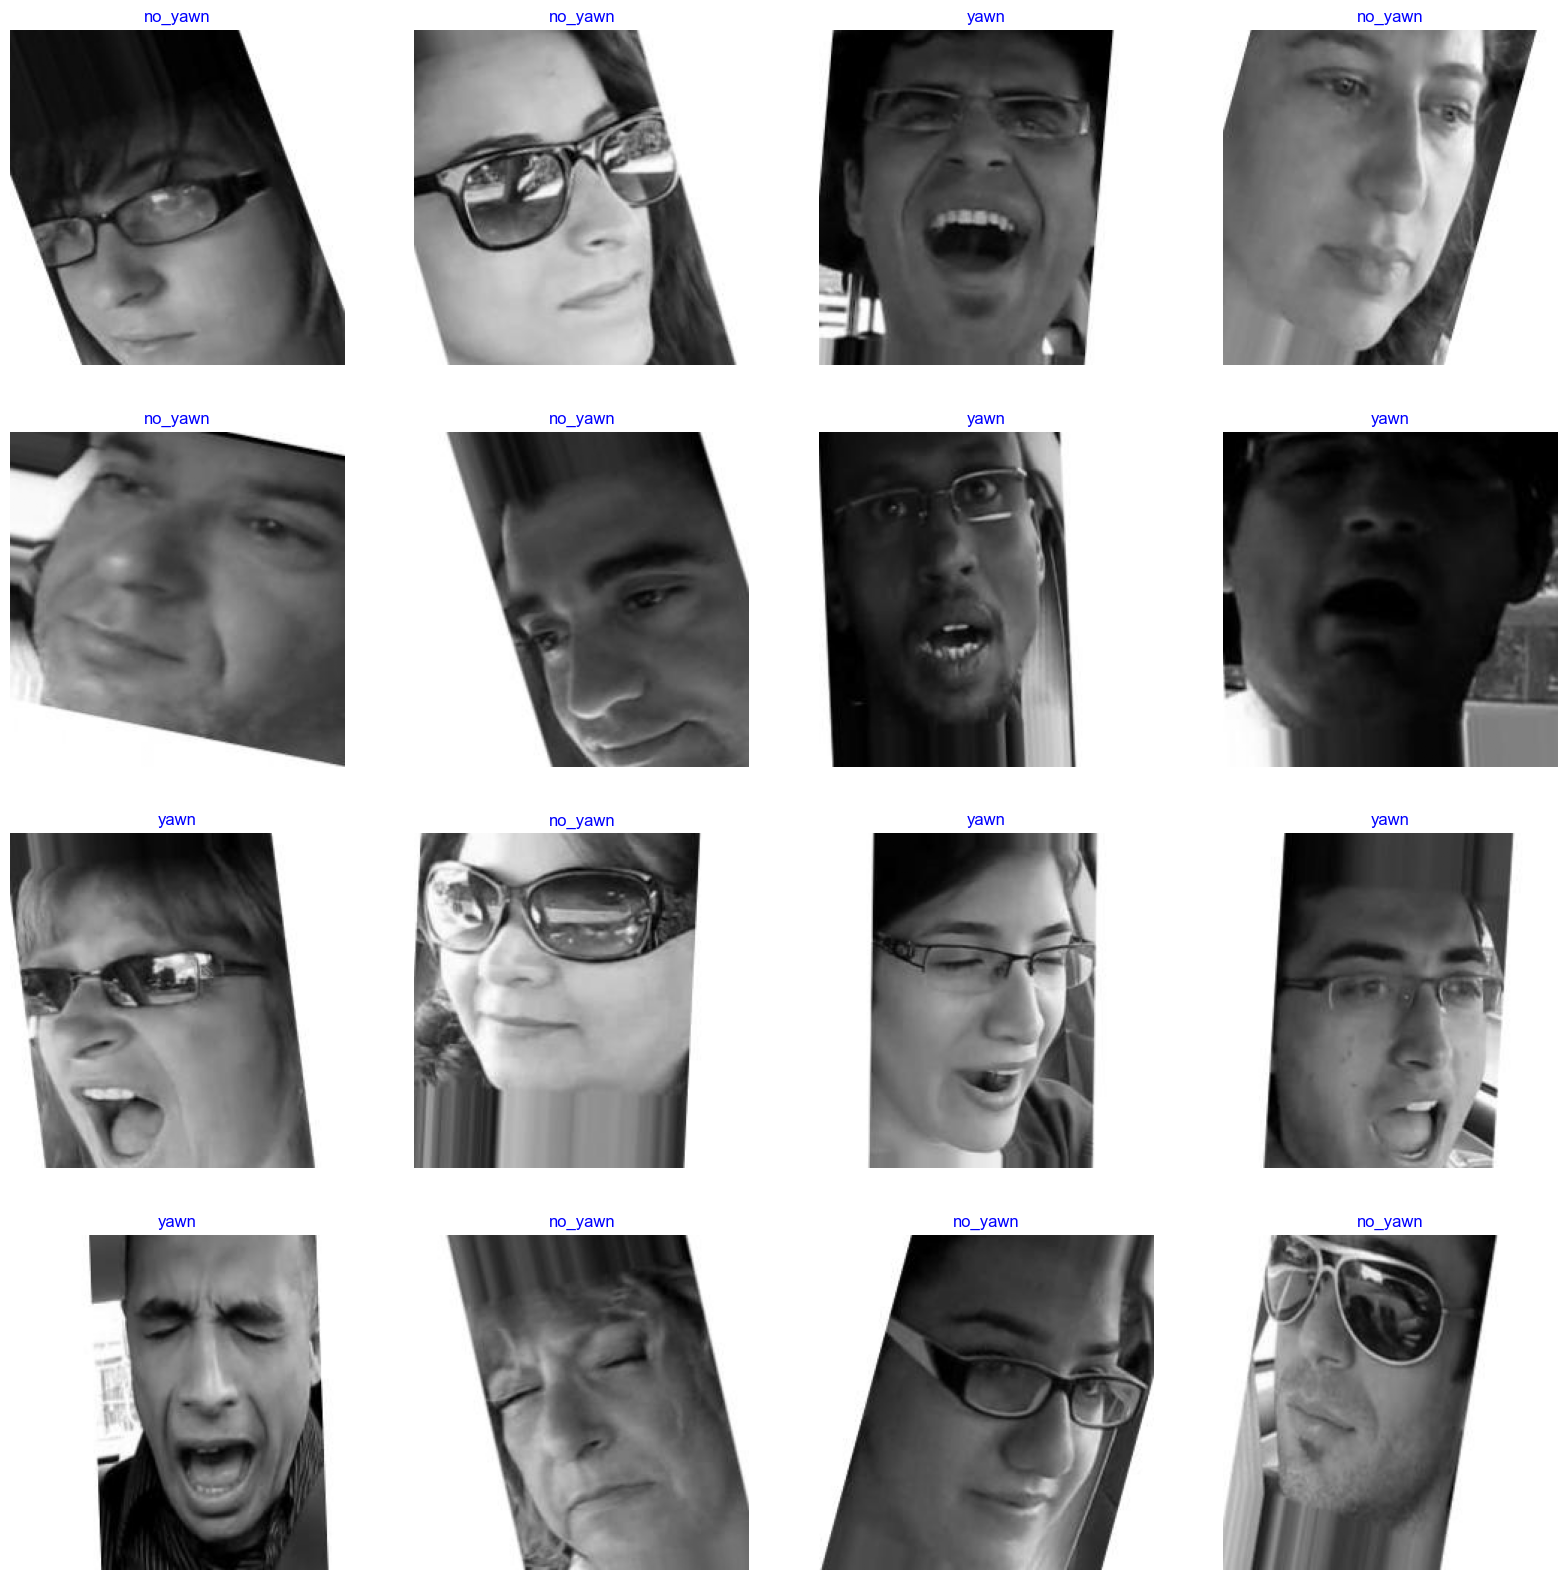

In [7]:
gen_dict = train_generator.class_indices      # defines dictionary {'class': index}
classes_list = list(gen_dict.keys())       # defines a list of dictionary's keys (classes), class names: string
images, labels = next(train_generator)      # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to the range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get the image index
    class_name = classes_list[index]   # get the class of the image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

# **Model Structure**

In [29]:
# Create Model Structure
image_size = (224, 224)
channels = 3
img_shape = (image_size[0], image_size[1], channels)
# we will use efficientnetb0 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 224, 224, 3)  0          ['normalization[0][0

#### **Model Creation**

In [8]:
class_count = len(list(train_generator.class_indices.keys()))  # to define the number of classes in the dense layer

# we will use efficientnetb0 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non-trainable params: 44,583
_________________________________________

#### **Train model**

In [9]:
batch_size = 16   # set batch size for training
epochs = 5   # number of all epochs in training

history = model.fit(x=train_generator, epochs=epochs, verbose=1, validation_data=valid_generator, validation_steps=None, shuffle=False)


Epoch 1/5
2651/2651 [==============================] - 684s 251ms/step - loss: 1.0198 - accuracy: 0.9849 - val_loss: 0.0921 - val_accuracy: 0.9975
Epoch 2/5
2651/2651 [==============================] - 876s 331ms/step - loss: 0.0761 - accuracy: 0.9983 - val_loss: 0.0575 - val_accuracy: 0.9982
Epoch 3/5
2651/2651 [==============================] - 892s 337ms/step - loss: 0.0553 - accuracy: 0.9986 - val_loss: 0.0429 - val_accuracy: 0.9992
Epoch 4/5
2651/2651 [==============================] - 794s 300ms/step - loss: 0.0441 - accuracy: 0.9995 - val_loss: 0.0360 - val_accuracy: 0.9991
Epoch 5/5
2651/2651 [==============================] - 843s 318ms/step - loss: 0.0381 - accuracy: 0.9996 - val_loss: 0.0328 - val_accuracy: 0.9991


#### **Display model performance**

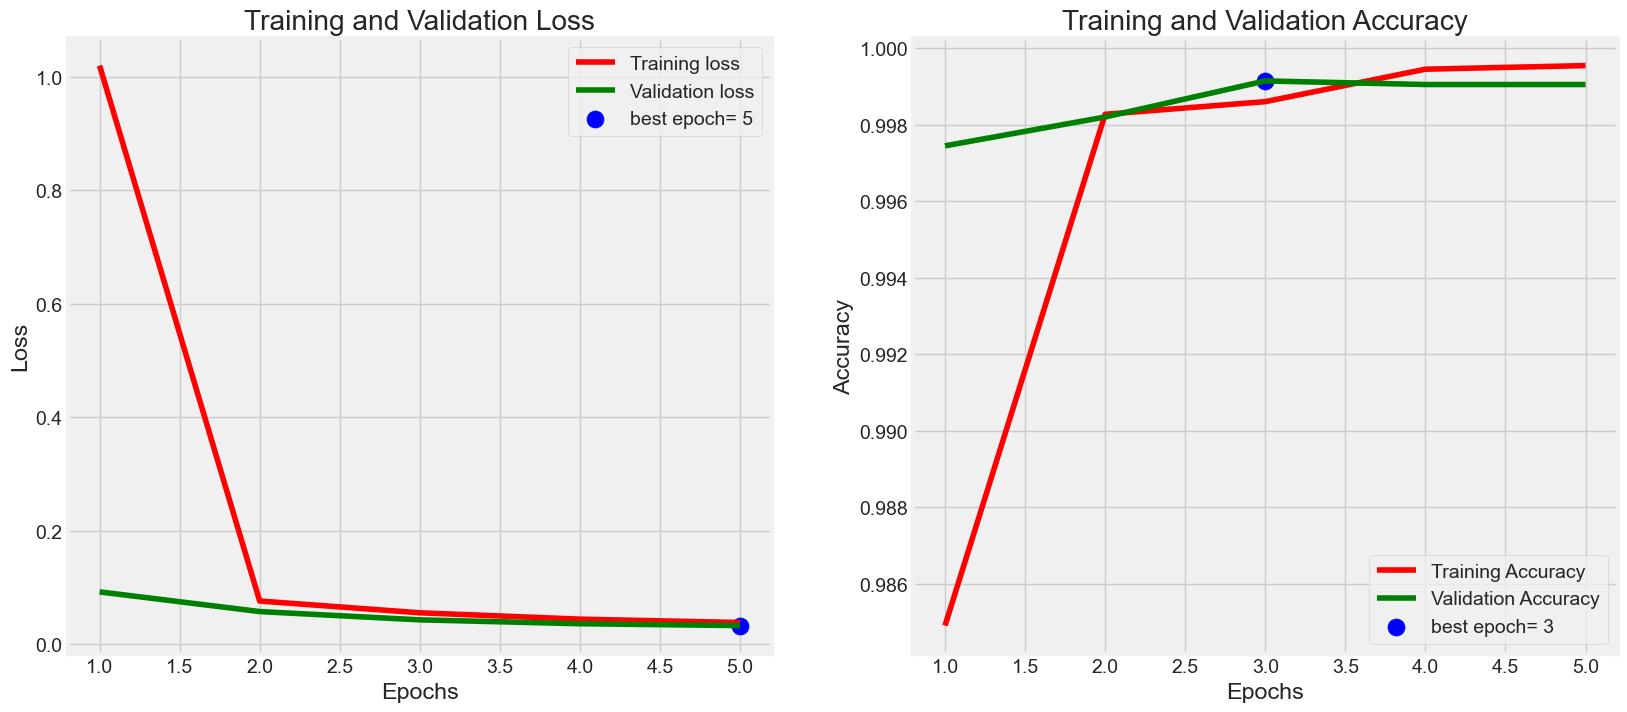

In [10]:
# Define needed variables
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']
index_loss = np.argmin(validation_loss)
lowest_validation_loss = validation_loss[index_loss]
index_accuracy = np.argmax(validation_accuracy)
highest_accuracy = validation_accuracy[index_accuracy]
epochs_list = [i + 1 for i in range(len(training_accuracy))]
loss_label = f'best epoch= {str(index_loss + 1)}'
accuracy_label = f'best epoch= {str(index_accuracy + 1)}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs_list, training_loss, 'r', label='Training loss')
plt.plot(epochs_list, validation_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, lowest_validation_loss, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, training_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs_list, validation_accuracy, 'g', label='Validation Accuracy')
plt.scatter(index_accuracy + 1, highest_accuracy, s=150, c='blue', label=accuracy_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


# **Evaluate model**

In [11]:
test_length = len(test_df)
test_batch_size = max(sorted([test_length // n for n in range(1, test_length + 1) if test_length % n == 0 and test_length / n <= 80]))
test_steps = test_length // test_batch_size

train_score = model.evaluate(train_generator, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_generator, steps=test_steps, verbose=1)
test_score = model.evaluate(test_generator, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25/25 [==============================] - 27s 901ms/step - loss: 0.0294 - accuracy: 1.0000
Train Loss:  0.029427146539092064
Train Accuracy:  1.0
--------------------
Validation Loss:  0.032253045588731766
Validation Accuracy:  0.9975000023841858
--------------------
Test Loss:  0.029440714046359062
Test Accuracy:  1.0


# **Get Predictions**

In [12]:
predictions = model.predict_generator(test_generator)
y_pred = np.argmax(predictions, axis=1)

C:\Users\Afraz\AppData\Local\Temp\ipykernel_32304\2815406075.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


#### **Confusion Matrics and Classification Report**

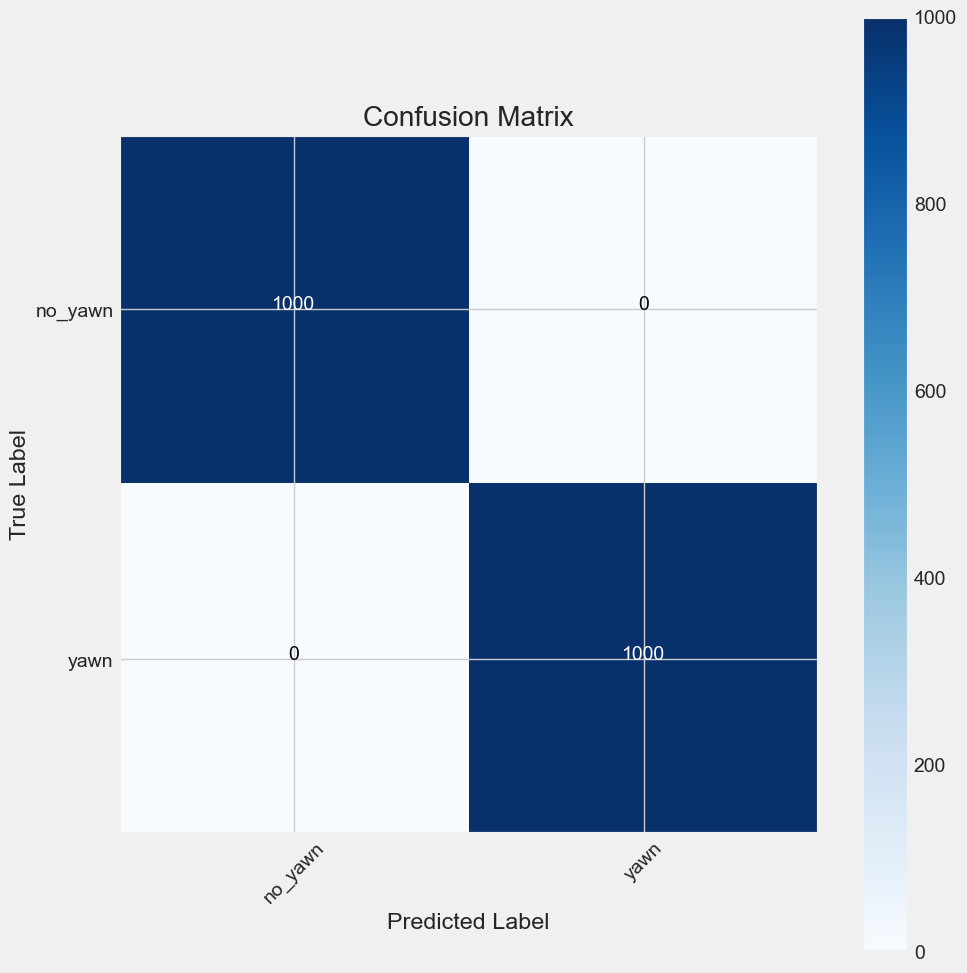

In [13]:
gen_dict = test_generator.class_indices
classes_list = list(gen_dict.keys())

# Confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes_list))
plt.xticks(tick_marks, classes_list, rotation=45)
plt.yticks(tick_marks, classes_list)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', color='white' if conf_matrix[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

     no_yawn       1.00      1.00      1.00      1000
        yawn       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



#### **Save model**

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'YawnDetection'
accuracy_percentage = test_score[1] * 100
save_path = '/model'

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" % round(accuracy_percentage, 2)}.h5')
model_save_location = os.path.join(save_path, "ENB_yawn.h5")
model.save(model_save_location)
print(f'Model was saved as {model_save_location}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_location = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_location)
print(f'Weights were saved as {weights_save_location}')

model was saved as ENB_yawn.h5
weights were saved as efficientnetb0-YawnDetection-weights.h5
